
Generating image 1/4...
Image successfully downloaded: lighthouse_1.png
Final image saved: final_pocket_image_1.png

Generating image 2/4...
Image successfully downloaded: lighthouse_2.png
Final image saved: final_pocket_image_2.png

Generating image 3/4...
Image successfully downloaded: lighthouse_3.png
Final image saved: final_pocket_image_3.png

Generating image 4/4...
Image successfully downloaded: lighthouse_4.png
Final image saved: final_pocket_image_4.png

Displaying all generated images:


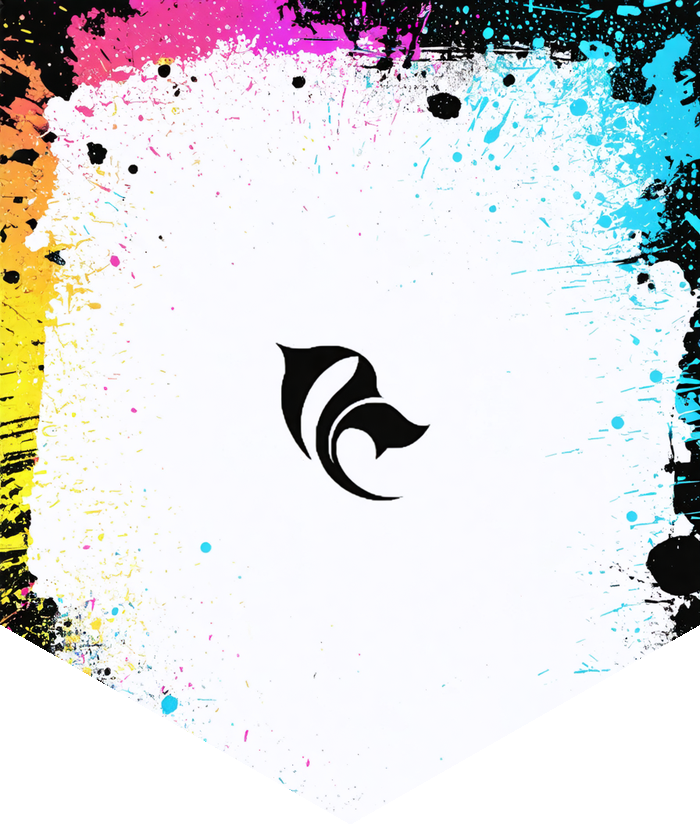

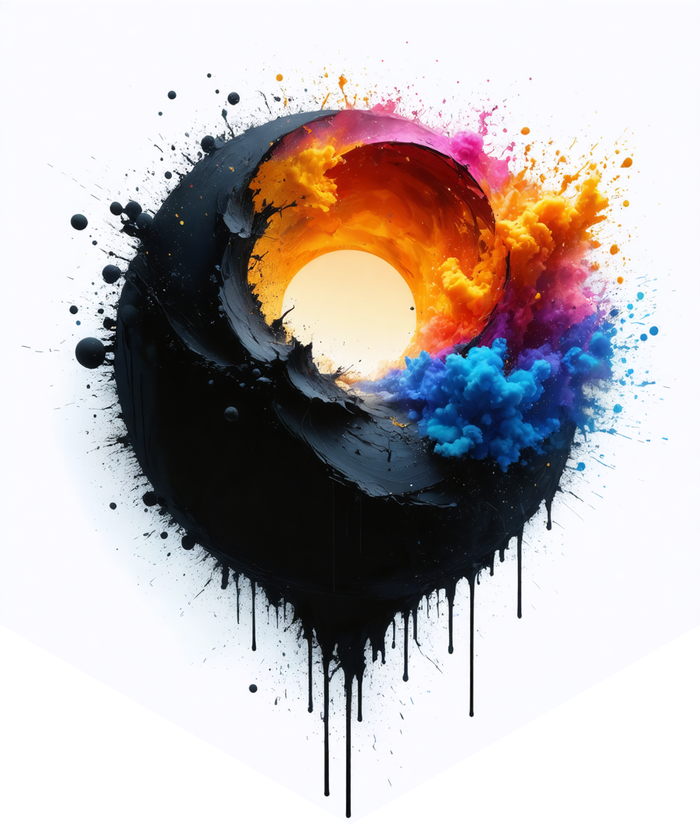

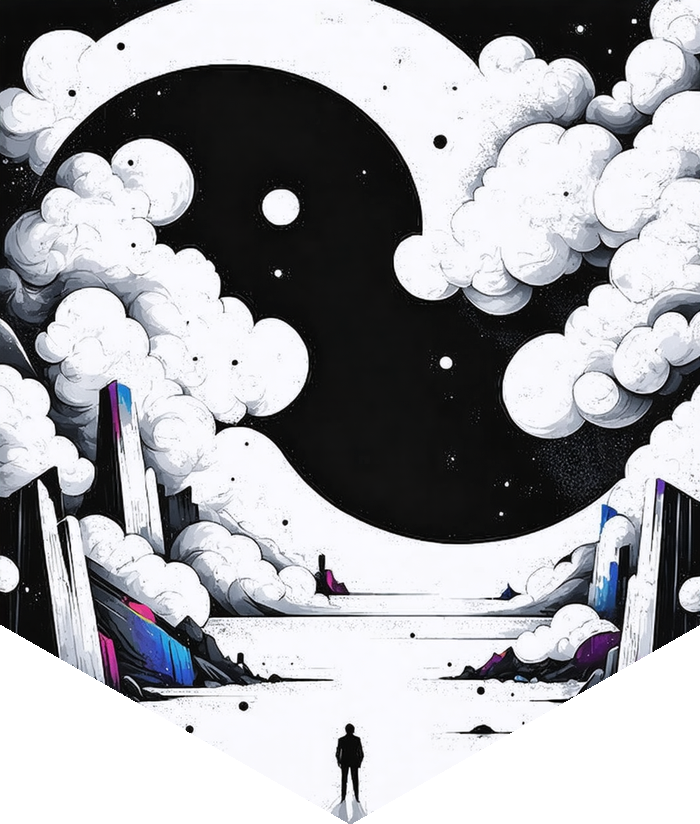

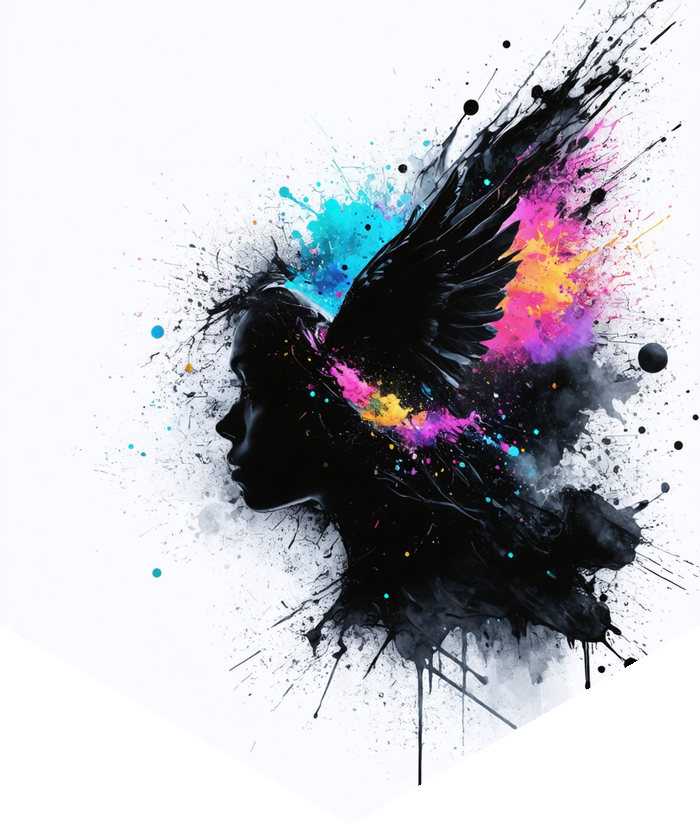

In [2]:
# Import necessary libraries
import os
import requests
from PIL import Image, ImageDraw
from dotenv import load_dotenv
from IPython.display import display
import ipywidgets as widgets

# Load environment variables from the .env file
load_dotenv()
STABILITY_API_KEY = os.getenv("STABILITY_API_KEY")

# StabilityAI API URL (ensure this is the correct endpoint as per the official documentation)
STABILITY_API_URL = "https://api.stability.ai/v2beta/stable-image/generate/ultra"

# Define the global prompt template
GLOBAL_PROMPT_TEMPLATE = (
    "Create a {image_type} with a {color_scheme} color scheme based on the following description: \"{user_prompt}\". "
    "The {image_type} should be simple, modern, and easily recognizable and take in account it will be put on a clothes"
)

def generate_custom_image(api_key, user_prompt, output_path, aspect_ratio="1:1", output_format="png", 
                         color_scheme="black and white", image_type="logo"):
    """
    Generates an image using the user's prompt via StabilityAI with a global prompt.

    Args:
        api_key (str): StabilityAI API key.
        user_prompt (str): User-provided prompt.
        output_path (str): Path to save the generated image.
        aspect_ratio (str): Aspect ratio of the image (default: "1:1").
        output_format (str): Image format (default: "png").
        color_scheme (str): Color scheme for the image (default: "black and white").
        image_type (str): Type of image to create (default: "logo").

    Returns:
        bool: True if the image is successfully generated and saved, else False.
    """
    headers = {
        "authorization": f"Bearer {api_key}",
        "Accept": "image/*, application/json",
    }

    # Construct the global prompt by injecting user prompt and other variables
    global_prompt = GLOBAL_PROMPT_TEMPLATE.format(
        image_type=image_type,
        color_scheme=color_scheme,
        user_prompt=user_prompt
    )

    # Prepare data for multipart/form-data
    files = {
        "prompt": (None, global_prompt),
        "aspect_ratio": (None, aspect_ratio),
        "output_format": (None, output_format),
    }

    try:
        response = requests.post(STABILITY_API_URL, headers=headers, files=files, stream=True)
        
        if response.status_code == 200:
            content_type = response.headers.get('Content-Type', '')
            if 'image' in content_type:
                # Save the generated image directly
                with open(output_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                print(f"Image successfully downloaded: {output_path}")
                return True
            elif 'application/json' in content_type:
                # Handle JSON response (e.g., image URL)
                response_data = response.json()
                image_url = response_data.get("image_url")  # Adjust based on actual response structure
                if image_url:
                    img_response = requests.get(image_url, stream=True)
                    if img_response.status_code == 200:
                        with open(output_path, "wb") as f:
                            for chunk in img_response.iter_content(chunk_size=8192):
                                f.write(chunk)
                        print(f"Image successfully downloaded from URL: {output_path}")
                        return True
                    else:
                        print(f"Error downloading image from URL: {img_response.status_code} - {img_response.text}")
                        return False
                else:
                    print("Image URL not found in the response.")
                    return False
            else:
                print(f"Unexpected content type in response: {content_type}")
                return False
        else:
            print(f"Error generating image: {response.status_code} - {response.text}")
            return False
    except Exception as e:
        print(f"Request error: {e}")
        return False

def apply_pocket_shape(image_path, output_path, pocket_size=(700, 1124)):
    """
    Adjusts the image to have a pocket format with a triangular base.

    Args:
        image_path (str): Path to the source image.
        output_path (str): Path to save the final image.
        pocket_size (tuple): Dimensions of the pocket in pixels (width, height).

    Returns:
        str: Path to the final image.
    """
    # Open and resize the generated image
    image = Image.open(image_path).resize(pocket_size, Image.LANCZOS)
    
    # Create a mask in the shape of the pocket
    mask = Image.new("L", pocket_size, 0)
    draw = ImageDraw.Draw(mask)
    
    # Draw a polygon with a triangular base
    width, height = pocket_size
    draw.polygon([
        (0, 0),                 # Top-left corner
        (width, 0),             # Top-right corner
        (width, height - 200),  # Right side before the triangle
        (width // 2, height),   # Tip of the triangle at the center
        (0, height - 200)       # Left side before the triangle
    ], fill=255)
    
    # Apply the mask to create the shaped image
    shaped_image = Image.new("RGBA", pocket_size)
    shaped_image.paste(image, (0, 0), mask)
    
    # Save the final image
    shaped_image.save(output_path, "PNG")
    print(f"Final image saved: {output_path}")
    return output_path

# Function to display images in Jupyter
def display_images(image_paths):
    """
    Displays multiple images in a Jupyter Notebook.

    Args:
        image_paths (list): List of image file paths to display.
    """
    for img_path in image_paths:
        try:
            image = Image.open(img_path)
            display(image)
        except Exception as e:
            print(f"Error displaying image {img_path}: {e}")

# Example Usage
def main():
    # Verify that the API key is loaded
    if not STABILITY_API_KEY:
        raise ValueError("StabilityAI API key not found in environment variables.")
    
    # User prompt
    user_prompt = "Surreal explosion of colors."
    
    # Define number of images to generate
    num_images = 4
    
    # Paths to save images
    GENERATED_IMAGE_PATHS = [f"lighthouse_{i+1}.png" for i in range(num_images)]
    FINAL_IMAGE_PATHS = [f"final_pocket_image_{i+1}.png" for i in range(num_images)]
    
    # Pocket dimensions in pixels
    POCKET_WIDTH = 700
    POCKET_HEIGHT = 824
    
    # Desired color scheme
    COLOR_SCHEME = "black and white"  # Can be customized or made dynamic
    
    # List to store final image paths for display
    final_images = []
    
    try:
        for i in range(num_images):
            print(f"\nGenerating image {i+1}/{num_images}...")
            generated_path = GENERATED_IMAGE_PATHS[i]
            final_path = FINAL_IMAGE_PATHS[i]
            
            # Step 1: Generate an image with StabilityAI using the global prompt
            success = generate_custom_image(
                STABILITY_API_KEY,
                user_prompt,
                generated_path,
                aspect_ratio="4:5",
                color_scheme=COLOR_SCHEME,
                image_type="logo"
            )
            
            if success:
                # Step 2: Apply the triangular pocket format
                apply_pocket_shape(generated_path, final_path, pocket_size=(POCKET_WIDTH, POCKET_HEIGHT))
                final_images.append(final_path)
            else:
                print(f"Image {i+1} generation failed.")
        
        # Step 3: Display all final images in Jupyter
        print("\nDisplaying all generated images:")
        display_images(final_images)
    
    except Exception as e:
        print(f"Error: {e}")

# Execute the main function
if __name__ == "__main__":
    main()
